####**Linking Kaggle and Getting Embeddings**

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krakit1","key":"59dc3fcd67bc0ad38bd9a71676fe0cd9"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2020-05-25 05:02:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip.1’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  12.2MB/s    in 2m 1s   

2020-05-25 05:04:15 (12.0 MB/s) - ‘crawl-300d-2M.vec.zip.1’ saved [1523785255/1523785255]



In [28]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip.1
  inflating: crawl-300d-2M.vec       


####**Imports**

In [6]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

TensorFlow 1.x selected.


####**F1 score function**

In [0]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

###**Sentiment Model**

####**Getting Data**

In [0]:
!kaggle datasets download -d kazanova/sentiment140

100% 80.9M/80.9M [00:02<00:00, 32.9MB/s]



In [0]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


####**Preprocessing Data and Preparing Embedding Weights**

In [0]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1')
df.columns = ['target', 'id','date', 'flag', 'user', 'text']
df['target'] = df['target'].map({4:1, 0:0})
df = df.drop(['date', 'id', 'flag', 'user'], axis=1)
# print(df.head())
# print(df['target'].value_counts())

64


(array([5.9780e+03, 2.5113e+04, 5.2064e+04, 6.7905e+04, 8.0835e+04,
        8.7307e+04, 8.9283e+04, 8.8847e+04, 8.7014e+04, 0.0000e+00,
        8.3542e+04, 8.0406e+04, 7.6013e+04, 7.1814e+04, 6.7854e+04,
        6.3609e+04, 6.0014e+04, 5.6220e+04, 5.3751e+04, 0.0000e+00,
        5.1777e+04, 5.1499e+04, 4.8382e+04, 4.7695e+04, 4.5550e+04,
        4.2597e+04, 3.7359e+04, 2.9781e+04, 2.1201e+04, 0.0000e+00,
        1.3212e+04, 7.3180e+03, 3.5760e+03, 1.5550e+03, 5.9400e+02,
        2.1500e+02, 7.4000e+01, 2.2000e+01, 8.0000e+00, 0.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6

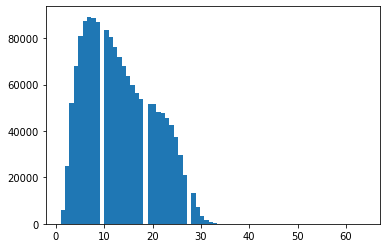

In [9]:
temp1 = df['text'].apply(lambda x : len(x.split()))
print(max(temp1))
plt.hist(temp1, bins=70)

In [0]:
X = np.array(df['text'])
y = np.array(df['target'])

y = y.reshape((y.shape[0],1))
X = X.squeeze()

m = X.shape[0]
perm = np.random.permutation(m)
X = X[perm]
y = y[perm,:]

X = X[:60000]
y = y[:60000,:]

X_test = X[:10000]
y_test = y[:10000,:]

X_val = X[10000:20000]
y_val = y[10000:20000,:]

X_train = X[20000:]
y_train = y[20000:,:]

In [11]:
max_len = min(max(len(x.split()) for x in X_train), 20)
embedding_size = 300
embedding_file = 'crawl-300d-2M.vec'
print("max length:",max_len)

max length: 20


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train))

X = tokenizer.texts_to_sequences(list(X_train))
X_train = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_val))
X_val = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_test))
X_test = np.array(pad_sequences(X, max_len))

print(y_train.shape, X_train.shape)
print(y_val.shape, X_val.shape)
print(y_test.shape, X_test.shape)

(40000, 1) (40000, 20)
(10000, 1) (10000, 20)
(10000, 1) (10000, 20)


In [13]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab:", vocab_size)

vocab: 51101


In [0]:
def get_indices(word, *arr):
    return word,np.asarray(arr, dtype=np.float32)

word_to_vec = dict(get_indices(*i.rstrip().rsplit()) for i in open(embedding_file))

embedding_matrix_S = np.zeros((vocab_size, embedding_size))

for word,i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None:
        embedding_matrix_S[i] = embedding_vector

####**Model**

In [0]:
def sentiment():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        embedding_size, 
                                        input_length=max_len, 
                                        weights=[embedding_matrix_S], 
                                        trainable=True,
                                        name='Embedding_S'))
    
    model.add(tf.keras.layers.Conv1D(filters=50,
                                     kernel_size=5,
                                     activation='relu',
                                     name='conv1_S'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool1_S'))

    model.add(tf.keras.layers.Conv1D(filters=100,
                                     kernel_size=3,
                                     activation='relu',
                                     name='conv2_S'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool2_S'))
    model.add(tf.keras.layers.Flatten(name='flatten1_S'))

    model.add(tf.keras.layers.Dense(100, activation='relu', name='dense1_S'))
    model.add(tf.keras.layers.Dropout(0.75, name='dropout1_S'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_S'))

    return model

In [16]:
batch_size = 32
epochs = 10
learning_rate = 1e-5

model = sentiment()
checkpointer = ModelCheckpoint(filepath = 'sentiment.hdf5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
39872/40000 [============================>.] - ETA: 0s - loss: 0.6969 - acc: 0.5126 - f1_m: 0.5011
Epoch 00001: val_loss improved from inf to 0.68862, saving model to sentiment.hdf5
40000/40000 [==============================] - 16s 411us/sample - loss: 0.6969 - acc: 0.5126 - f1_m: 0.5009 - val_loss: 0.6886 - val_acc: 0.5555 - val_f1_m: 0.5091
Epoch 2/10
39872/40000 [============================>.] - ETA: 0s - loss: 0.6892 - acc: 0.5354 - f1_m: 0.5221
Epoch 00002: val_loss improved from 0.68862 to 0.68287, saving model to sentiment.hdf5
40000/40000 [==============================] - 10s 246us/sample - loss: 0.6892 - acc: 0.5354 - f1_m: 0.

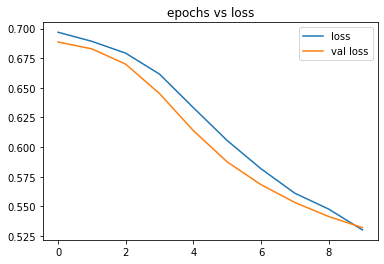

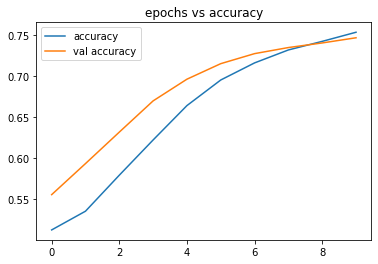

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

**Test Set Performance**

In [18]:
model.load_weights('sentiment.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 65us/sample - loss: 0.5306 - acc: 0.7493 - f1_m: 0.7385


In [19]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.5306076684951783
Accuracy on test set: 0.7493
F1 score on test set: 0.7384675


In [20]:
S = sentiment()
S.load_weights('sentiment.hdf5')

###**Sarcasm Model**

####**Getting Data**

In [15]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 111MB/s]


In [16]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


####**Preprocessing Data and Preparing Embedding Weights**

In [21]:
df1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = pd.concat([df1[['headline', 'is_sarcastic']],df2[['headline', 'is_sarcastic']]], axis=0)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [22]:
temp1 = df1['headline'].apply(lambda x : len(x.split()))
print(max(temp1))
temp = df2['headline'].apply(lambda x : len(x.split()))
print(max(temp))

39
151


(array([1.170e+02, 3.040e+02, 5.790e+02, 1.141e+03, 1.727e+03, 2.347e+03,
        2.853e+03, 3.302e+03, 3.486e+03, 3.197e+03, 2.644e+03, 1.863e+03,
        1.282e+03, 0.000e+00, 7.940e+02, 4.380e+02, 2.850e+02, 1.670e+02,
        8.100e+01, 3.900e+01, 2.600e+01, 1.400e+01, 8.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 2.   ,  2.925,  3.85 ,  4.775,  5.7  ,  6.625,  7.55 ,  8.475,
         9.4  , 10.325, 11.25 , 12.175, 13.1  , 14.025, 14.95 , 15.875,
        16.8  , 17.725, 18.65 , 19.575, 20.5  , 21.425, 22.35 , 23.275,
        24.2  , 25.125, 26.05 , 26.975, 27.9  , 28.825, 29.75 , 30.675,
        31.6  , 32.525, 33.45 , 34.375, 35.3  , 36.225, 37.15 , 38.075,
        39.   ]),
 <a list of 40 Patch objects>)

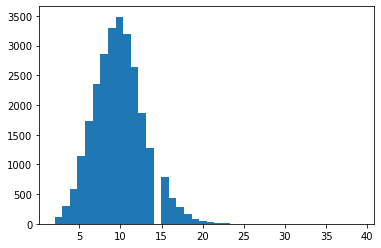

In [23]:
plt.hist(temp1, bins=40)

(array([1.180e+02, 3.060e+02, 5.910e+02, 1.164e+03, 1.762e+03, 2.404e+03,
        2.935e+03, 3.425e+03, 3.638e+03, 3.396e+03, 2.841e+03, 2.083e+03,
        1.492e+03, 9.690e+02, 5.780e+02, 3.830e+02, 2.280e+02, 1.430e+02,
        6.300e+01, 4.500e+01, 2.300e+01, 1.200e+01, 5.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

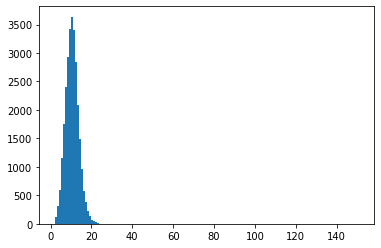

In [24]:
plt.hist(temp, bins=150)

In [25]:
print (df['is_sarcastic'].value_counts())

0    29970
1    25358
Name: is_sarcastic, dtype: int64


In [0]:
# df = df.drop(['article_link'],axis=1)
# df['len'] = df['headline'].apply(lambda x : len(x.split()))

In [0]:
X = np.array(df['headline'])
y = np.array(df['is_sarcastic'])

y = y.reshape((y.shape[0],1))
X = X.squeeze()
m = X.shape[0]
perm = np.random.permutation(m)
X = X[perm]
y = y[perm,:]

X_test = X[:10000]
y_test = y[:10000,:]

X_val = X[10000:20000]
y_val = y[10000:20000,:]

X_train = X[20000:]
y_train = y[20000:,:]

In [28]:
max_len = min(max(len(x.split()) for x in X_train), 20) #25 when used lstm, 98% accuracy
embedding_size = 300
embedding_file = 'crawl-300d-2M.vec'
print("max length:",max_len)

max length: 20


In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train))

X = tokenizer.texts_to_sequences(list(X_train))
X_train = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_val))
X_val = np.array(pad_sequences(X, max_len))

X = tokenizer.texts_to_sequences(list(X_test))
X_test = np.array(pad_sequences(X, max_len))

print(y_train.shape, X_train.shape)
print(y_val.shape, X_val.shape)
print(y_test.shape, X_test.shape)

(35328, 1) (35328, 20)
(10000, 1) (10000, 20)
(10000, 1) (10000, 20)


In [30]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(vocab_size)

28514


In [0]:
def get_indices(word, *arr):
    return word,np.asarray(arr, dtype=np.float32)

word_to_vec = dict(get_indices(*i.rstrip().rsplit()) for i in open(embedding_file))

embedding_matrix_B = np.zeros((vocab_size, embedding_size))

for word,i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None:
        embedding_matrix_B[i] = embedding_vector

####**CNN Model**

In [0]:
def baseline():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, 
                                        embedding_size, 
                                        input_length=max_len, 
                                        weights=[embedding_matrix_B], 
                                        trainable=True,
                                        name='Embedding_B'))
    
    model.add(tf.keras.layers.Conv1D(filters=50,
                                     kernel_size=5,
                                     activation='relu',
                                     name='conv1_B'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool1_B'))

    model.add(tf.keras.layers.Conv1D(filters=100,
                                     kernel_size=3,
                                     activation='relu',
                                     name='conv2_B'))
    model.add(tf.keras.layers.MaxPooling1D(2, name='max_pool2_B'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(100, activation='relu', name='dense1_B'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout1_B'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_B'))

    return model

In [33]:
batch_size = 32
epochs = 10
learning_rate = 5e-5

model = baseline()
checkpointer = ModelCheckpoint(filepath = 'baseline.hdf5', 
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Train on 35328 samples, validate on 10000 samples
Epoch 1/10
35136/35328 [============================>.] - ETA: 0s - loss: 0.5903 - acc: 0.6809 - f1_m: 0.5653
Epoch 00001: val_loss improved from inf to 0.42764, saving model to baseline.hdf5
35328/35328 [==============================] - 8s 220us/sample - loss: 0.5895 - acc: 0.6815 - f1_m: 0.5664 - val_loss: 0.4276 - val_acc: 0.8187 - val_f1_m: 0.7866
Epoch 2/10
35264/35328 [============================>.] - ETA: 0s - loss: 0.3424 - acc: 0.8572 - f1_m: 0.8392
Epoch 00002: val_loss improved from 0.42764 to 0.32051, saving model to baseline.hdf5
35328/35328 [==============================] - 7s 209us/sample - loss: 0.3425 - acc: 0.8571 - f1_m: 0.8391 - val_loss: 0.3205 - val_acc: 0.8684 - val_f1_m: 0.8478
Epoch 3/10
35168/35328 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9055 - f1_m: 0.8928
Epoch 00003: val_loss improved from 0.32051 to 0.27347, saving model to baseline.hdf5
35328/35328 [===========================

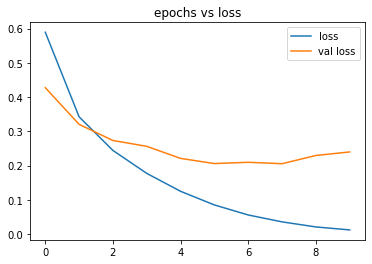

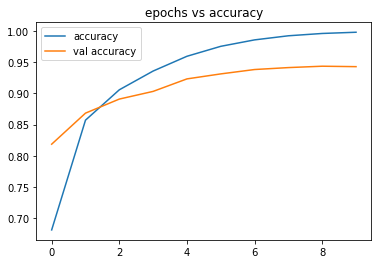

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()

**Test Set Performance**

In [35]:
model.load_weights('baseline.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 69us/sample - loss: 0.1974 - acc: 0.9422 - f1_m: 0.9358


In [36]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.1973807864330709
Accuracy on test set: 0.9422
F1 score on test set: 0.9357907


In [0]:
B = baseline()
B.load_weights('baseline.hdf5')

####**CNN-SVM Model**

In [38]:
from sklearn import svm

m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dropout1_B').output)
t = m_temp.predict(X_train)
arr = K.eval(t)

clf = svm.SVC(kernel='rbf', C=20, gamma=.1)
clf.fit(arr, y_train.ravel())

SVC(C=20, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
import sklearn

m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dense1_B').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
ans = clf.predict(tt)

tt = m_temp.predict(X_train)
tt = K.eval(tt)
trn = clf.predict(tt)

tt = m_temp.predict(X_val)
tt = K.eval(tt)
val = clf.predict(tt)
print("Train Acc:", sklearn.metrics.accuracy_score(y_train.ravel(), trn))
print("Val Acc:", sklearn.metrics.accuracy_score(y_val.ravel(), val))
print("Test Acc:", sklearn.metrics.accuracy_score(y_test.ravel(), ans))

Train Acc: 0.9980751811594203
Val Acc: 0.9426
Test Acc: 0.9433


###**Model Combination**

####**Baseline with Sentiment**

In [0]:
sentiment_model = tf.keras.Model(inputs=S.input, outputs=S.get_layer('dropout1_S').output)
baseline_model = tf.keras.Model(inputs=B.input, outputs=B.get_layer('dropout1_B').output)

sentiment_model.trainable = True
baseline_model.trainable = True

In [0]:
def combined():
    ip = tf.keras.Input(shape=(max_len,))

    x1 = sentiment_model(ip)
    x2 = baseline_model(ip)
    z = tf.keras.layers.concatenate([x2,x1], axis=1)
    z = tf.keras.layers.Flatten(name='flatten1_C')(z)
    z = tf.keras.layers.Dropout(0.65, name='dropout1_C')(z)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(z)

    model = tf.keras.Model(inputs=ip, outputs=out)
    
    return model

In [42]:
batch_size = 32
epochs = 10
learning_rate = 1e-5

model = combined()
checkpointer = ModelCheckpoint(filepath = 'combined.hdf5', 
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True,
                               mode='min')

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', f1_m])

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Train on 35328 samples, validate on 10000 samples
Epoch 1/10
35264/35328 [============================>.] - ETA: 0s - loss: 0.6454 - acc: 0.6632 - f1_m: 0.6144
Epoch 00001: val_loss improved from inf to 0.32989, saving model to combined.hdf5
35328/35328 [==============================] - 14s 386us/sample - loss: 0.6449 - acc: 0.6636 - f1_m: 0.6148 - val_loss: 0.3299 - val_acc: 0.9382 - val_f1_m: 0.9290
Epoch 2/10
35264/35328 [============================>.] - ETA: 0s - loss: 0.2991 - acc: 0.8901 - f1_m: 0.8739
Epoch 00002: val_loss improved from 0.32989 to 0.23474, saving model to combined.hdf5
35328/35328 [==============================] - 13s 368us/sample - loss: 0.2989 - acc: 0.8902 - f1_m: 0.8741 - val_loss: 0.2347 - val_acc: 0.9395 - val_f1_m: 0.9300
Epoch 3/10
35232/35328 [============================>.] - ETA: 0s - loss: 0.2028 - acc: 0.9420 - f1_m: 0.9339
Epoch 00003: val_loss improved from 0.23474 to 0.20156, saving model to combined.hdf5
35328/35328 [=========================

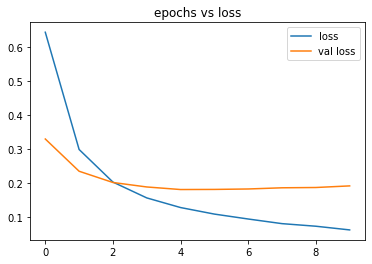

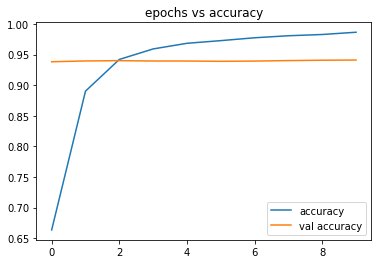

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.show()  

**Test Set Performance**

In [44]:
model.load_weights('combined.hdf5')
results = model.evaluate(X_test,
                         y_test,
                         batch_size=batch_size
                         )

10000/10000 [==============================] - 1s 78us/sample - loss: 0.1727 - acc: 0.9438 - f1_m: 0.9372


In [45]:
print("Loss on test set:", results[0])
print("Accuracy on test set:", results[1])
print ("F1 score on test set:", results[2])

Loss on test set: 0.1726510119020939
Accuracy on test set: 0.9438
F1 score on test set: 0.93724036


####**Combined SVM**

In [48]:
from sklearn import svm

m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dropout1_C').output)
t = m_temp.predict(X_train)
arr = K.eval(t)

clf = svm.SVC(kernel='rbf', C=25, gamma=.1)
clf.fit(arr, y_train.ravel())

SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
import sklearn

m_temp = tf.keras.Model(inputs=model.input, outputs=model.get_layer('flatten1_C').output)
tt = m_temp.predict(X_test)
tt = K.eval(tt)
ans = clf.predict(tt)

tt = m_temp.predict(X_train)
tt = K.eval(tt)
trn = clf.predict(tt)

tt = m_temp.predict(X_val)
tt = K.eval(tt)
val = clf.predict(tt)
print("Train Acc:", sklearn.metrics.accuracy_score(y_train.ravel(), trn))
print("Val Acc:", sklearn.metrics.accuracy_score(y_val.ravel(), val))
print("Test Acc:", sklearn.metrics.accuracy_score(y_test.ravel(), ans))

Train Acc: 0.998443161231884
Val Acc: 0.944
Test Acc: 0.9479
